In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             log_loss, matthews_corrcoef, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

At this website https://bioportal.bioontology.org/ontologies/ATC we can download the ATC 6799 
It is saved in 

# Cleaning of ATC database. We are interested in only Level-5 classes. 


In [3]:
atc_filename = 'atc.csv'
atc = pd.read_csv(atc_filename)
atc = atc[atc['ATC LEVEL'] == 5] # keep only level 5
atc = atc[atc['Obsolete'] != 'False'] # remove obsolete data


## Pick a subset as positive set, e.g., acne

In [88]:
atc_positive_A = atc[atc['Class ID'].str.contains('/D10A', na=False)]
atc_positive_B = atc[atc['Class ID'].str.contains('/D10B', na=False)]
atc_positive = atc[atc['Class ID'].str.contains('/D10', na=False)]
print(len(atc_positive_A), len(atc_positive_B)) 
atc_positive = set(atc_positive["Preferred Label"])
print(len(atc_positive))

34 2
35


In [129]:
atc_all = set(atc["Preferred Label"])
print(len(atc_all))

atc_negative = atc_all - atc_positive
print(len(atc_negative))

4686
4651


## Joinin with ATC compounds info

In [97]:
# atc_cpmds_batches = load_object_from_disk('atc_cpmds_batches.pkl')
all_atc_cpmds =  [item for sublist in atc_cpmds_batches for item in sublist.items()]
print(len(all_atc_cpmds))

6765


In [135]:
print("atc_positive: ", len(atc_positive))
all_atc_cpmds[0]
positive_data = [i for i in all_atc_cpmds if i[0] in atc_positive]
positive_data = list({k: v for k, v in positive_data if len(v) > 0}.items())
print("positive_data: ", len(positive_data))

positive_compounds = [v for k, v_list in positive_data for v in v_list]
print("positive_compounds: ", len(positive_compounds))

atc_positive:  35
positive_data:  27
positive_compounds:  27


In [134]:
print("atc_negative: ", len(atc_negative))
negative_data = [i for i in all_atc_cpmds if i[0] in atc_negative]
negative_data = list({k: v for k, v in negative_data if len(v) > 0}.items())
print("negative_data: ", len(negative_data))

negative_compounds = [v for k, v_list in negative_data for v in v_list]
print("negative_compounds: ", len(negative_compounds))


atc_negative:  4651
negative_data:  3120
negative_compounds:  4343


## Traning Data

In [136]:
negative_features = [getFeatures(compound) for compound in negative_compounds] 
positive_features = [getFeatures(compound) for compound in positive_compounds]
print(len(negative_features), len(positive_features))

4343 27


In [137]:
X = negative_features + positive_features
Y = [0] * len(negative_features) + [1] * len(positive_features)


In [138]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a DataFrame for features
df_X = pd.DataFrame(X)

# feature cleaning: some numbers are in string format, convert them to numbers
string_columns = df_X.select_dtypes(include='object').columns.tolist()
for i in string_columns:
    df_X[i] = pd.to_numeric(df_X[i])
    
# feature cleaning: replace NAN and INF with special values. They are rare in the data but cause errors if not replaced.
df_X.replace([np.nan], -1, inplace=True)
df_X.replace([np.inf], np.finfo(np.float32).max, inplace=True)
df_X.replace([-np.inf], np.finfo(np.float32).min, inplace=True)

# feature cleaning: some numbers in RDKit is too large for float32
df_X.loc[df_X['Ipc'] > 3.4028235e38, 'Ipc'] = np.finfo(np.float32).max  


X_train, X_test, y_train, y_test = train_test_split(df_X, Y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(
    n_estimators=48, 
    random_state=4999,
    max_features='sqrt',  # each tree use sqrt(230) features
    bootstrap=True  
)
model.fit(X_train, y_train)

# Evaluate model using cross-validation
scores = cross_val_score(model, X_test, y_test, cv=5)
print("Model Accuracy: ", np.mean(scores))

Model Accuracy:  0.994279146141215


In [141]:
save_object_to_disk(model, "model_2.pkl")

Object data has been serialized and saved to file.


In [140]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': df_X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
print(feature_importance_df)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

                         Feature  Importance
47                      BalabanJ    0.017111
143                      MolLogP    0.015674
60                         Chi4v    0.015256
123                  VSA_EState8    0.015115
35              FpDensityMorgan1    0.014272
23                MinEStateIndex    0.014004
56                         Chi2v    0.013311
20             MaxAbsEStateIndex    0.012948
19                         xlogp    0.012756
29           NumValenceElectrons    0.012746
86                      SMR_VSA5    0.012369
41                  BCUT2D_CHGLO    0.012179
43                BCUT2D_LOGPLOW    0.012149
95                    SlogP_VSA2    0.012106
111                  EState_VSA6    0.011947
55                         Chi2n    0.011883
12              molecular_weight    0.011781
98                    SlogP_VSA5    0.011637
21                MaxEStateIndex    0.011535
32              MinPartialCharge    0.011527
65                        Kappa3    0.011337
10        

# How the model work on the training data


In [142]:
X_positive_pred = pd.DataFrame(positive_features)
Y_positive_pred = model.predict_proba(X_positive_pred)
Y_positive_pred

array([[0.4375    , 0.5625    ],
       [0.3125    , 0.6875    ],
       [0.14583333, 0.85416667],
       [0.375     , 0.625     ],
       [0.14583333, 0.85416667],
       [1.        , 0.        ],
       [0.58194444, 0.41805556],
       [0.27083333, 0.72916667],
       [0.41666667, 0.58333333],
       [0.29166667, 0.70833333],
       [0.375     , 0.625     ],
       [0.95833333, 0.04166667],
       [0.45833333, 0.54166667],
       [1.        , 0.        ],
       [0.3125    , 0.6875    ],
       [0.375     , 0.625     ],
       [0.97916667, 0.02083333],
       [0.47916667, 0.52083333],
       [0.60590278, 0.39409722],
       [0.3125    , 0.6875    ],
       [0.39583333, 0.60416667],
       [0.27083333, 0.72916667],
       [0.35416667, 0.64583333],
       [0.35416667, 0.64583333],
       [0.39583333, 0.60416667],
       [0.3125    , 0.6875    ],
       [0.8125    , 0.1875    ]])

# DO THIS ONLY ONCE: Get Compound from PubChem

In [15]:
import pubchempy as pcp

def getCompounds(names):
    data = {}
    for chemical_name in names:
        compounds = pcp.get_compounds(chemical_name, 'name')
        data[chemical_name] = compounds
    return data


In [16]:
atc_cpmd_names_batches = [atc_cpmd_names[i:i + 30] for i in range(0, len(atc_cpmd_names), 30)]
atc_cpmd_names_batches

NameError: name 'atc_cpmd_names' is not defined

In [17]:
import time
atc_cpmds_batches = []
for index, batch in enumerate(atc_cpmd_names_batches):
    print(f"batch {index}")
    atc_cpmds = getCompounds(batch)
    atc_cpmds_batches.append(atc_cpmds)
    time.sleep(5)

NameError: name 'atc_cpmd_names_batches' is not defined

In [18]:
#save_object_to_disk(atc_cpmds_batches, 'atc_cpmds_batches.pkl')

# Get Features for Compound

In [28]:
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors


from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

DESCRIPTOR_NAMES = [desc_name[0] for desc_name in Descriptors._descList]


def getFeaturesFromPubChem(compound):
    x_dict = compound.to_dict()
    count_keys = ['atom_stereo_count', 'bond_stereo_count', 'charge', 'complexity', 'covalent_unit_count', 'defined_atom_stereo_count', 'defined_bond_stereo_count', 
              'exact_mass', 'h_bond_acceptor_count', 'h_bond_donor_count', 
              'heavy_atom_count', 
              'isotope_atom_count', 
              'molecular_weight', 'monoisotopic_mass', 
              'rotatable_bond_count', 'tpsa', 'undefined_atom_stereo_count', 'undefined_bond_stereo_count', 
              'volume_3d', 'xlogp']
    subset_dict = {key: x_dict[key] for key in count_keys}
    #print(subset_dict["exact_mass"])

    return subset_dict

def getRdkitMoleculeFromPubChemCompound(compound):
    return Chem.MolFromInchi(compound.inchi) 

def getFeaturesFromChem(molelcule, descriptor_names=DESCRIPTOR_NAMES):
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    descriptors = calculator.CalcDescriptors(molelcule)

    descriptor_dict = dict(zip(DESCRIPTOR_NAMES, descriptors))

    return descriptor_dict

def getFeaturesFromRdkit(compound, descriptor_names=DESCRIPTOR_NAMES):
    molecule = getRdkitMoleculeFromPubChemCompound(compound)
    
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    descriptors = calculator.CalcDescriptors(molecule)

    descriptor_dict = dict(zip(descriptor_names, descriptors))
    return descriptor_dict

def getFeatures(compound):
    dict_1 = getFeaturesFromPubChem(compound);
    dict_2 = getFeaturesFromRdkit(compound, DESCRIPTOR_NAMES)
    return dict_1 | dict_2


In [29]:
classification_features = [(entry[0], entry[1], getFeatures(entry[1])) for entry in all_atc_cpmds_clean] 

In [30]:
classification_features[0]

('mequinol',
 Compound(9015),
 {'atom_stereo_count': 0,
  'bond_stereo_count': 0,
  'charge': 0,
  'complexity': 75,
  'covalent_unit_count': 1,
  'defined_atom_stereo_count': 0,
  'defined_bond_stereo_count': 0,
  'exact_mass': '124.052429494',
  'h_bond_acceptor_count': 2,
  'h_bond_donor_count': 1,
  'heavy_atom_count': 9,
  'isotope_atom_count': 0,
  'molecular_weight': '124.14',
  'monoisotopic_mass': '124.052429494',
  'rotatable_bond_count': 1,
  'tpsa': 29.5,
  'undefined_atom_stereo_count': 0,
  'undefined_bond_stereo_count': 0,
  'volume_3d': None,
  'xlogp': 1.3,
  'MaxAbsEStateIndex': 8.796632653061225,
  'MaxEStateIndex': 8.796632653061225,
  'MinAbsEStateIndex': 0.26000000000000023,
  'MinEStateIndex': 0.26000000000000023,
  'qed': 0.6127725486570803,
  'SPS': 9.0,
  'MolWt': 124.13899999999998,
  'HeavyAtomMolWt': 116.07499999999997,
  'ExactMolWt': 124.052429496,
  'NumValenceElectrons': 48,
  'NumRadicalElectrons': 0,
  'MaxPartialCharge': 0.11862884646960266,
  'MinPa

In [376]:
save_object_to_disk(classification_features, 'classification_features.pkl')

Object data has been serialized and saved to file.


In [ ]:
classification_features = load_object_from_disk('classification_features.pkl')

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Create a DataFrame for features
df_X = pd.DataFrame([entry[2] for entry in classification_features])

In [15]:
df_X

,atom_stereo_count,bond_stereo_count,charge,complexity,covalent_unit_count,defined_atom_stereo_count,defined_bond_stereo_count,exact_mass,h_bond_acceptor_count,h_bond_donor_count,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,0,0,75.0,1,0,0,124.052429494,2,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,180.0,1,0,0,179.167399674,1,1,...,0,0,0,0,0,0,0,0,0,0
2,19,0,0,872.0,1,19,0,614.31228554,19,13,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,64.9,1,0,0,110.036779430,2,2,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,502.0,1,9,0,424.1798710,7,4,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5280,10,1,0,994.0,1,10,1,516.34508925,6,3,...,0,0,0,0,0,0,0,0,0,0
5281,5,0,0,971.0,1,5,0,444.15326573,9,6,...,0,0,0,0,0,0,0,0,0,0
5282,0,0,0,396.0,1,0,0,361.215412493,4,0,...,0,0,0,0,0,0,0,0,0,0
5283,0,0,0,222.0,1,0,0,229.0173527,1,2,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Convert all string columns to numbers
string_columns = df_X.select_dtypes(include='object').columns.tolist()
print(string_columns)
for i in string_columns:
    df_X[i] = pd.to_numeric(df_X[i])

['exact_mass', 'molecular_weight', 'monoisotopic_mass', 'volume_3d']


In [33]:
import numpy as np
# Replace inf and -inf with NaN

df_X.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

# Fill NaN values with the mean of the column
# df_X.fillna(df_X.mean(), inplace=True)

In [36]:
df_X.loc[df_X['Ipc'] > 3.4028235e38, 'Ipc'] = -1

# Obsolete: remove NAN and INF

In [67]:
import numpy as np
# print all inf and nan values
df = X_train

# Print all cells where the value is inf or NaN
inf_nan_cells = df[df.isin([np.inf, -np.inf, np.nan])].stack()
print("Cells with inf or NaN values:")
print(inf_nan_cells)

Cells with inf or NaN values:
Series([], dtype: float64)


In [68]:
np.any(np.isnan(X_train))

False

In [69]:
 np.any(np.isinf(X_train))

False

In [70]:
nan_indices = np.argwhere(np.isnan(X_train))

# Display indices of NaN values
print("Indices of NaN values:")
print(nan_indices)

Indices of NaN values:
[]


In [73]:
nan_indices = np.argwhere(np.isinf(X_train))

# Display indices of NaN values
print("Indices of NaN values:")
print(nan_indices)

Indices of NaN values:
[]


In [74]:
X_train.iloc[0,1]

0

# Single class with 

In [37]:
# this is out labels -- the atc classes
Y = [1 if i[0] in atc_positive_set else 0 for i in classification_features]
len([i for i in Y if i==1])

64

Model Accuracy:  0.987709022623625
Accuracy: 0.99
AUC: 0.99
Accuracy: 0.99
Precision: 1.00
Recall: 0.53
F1 Score: 0.69
Confusion Matrix:
[[1040    0]
 [   8    9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1040
           1       1.00      0.53      0.69        17

    accuracy                           0.99      1057
   macro avg       1.00      0.76      0.84      1057
weighted avg       0.99      0.99      0.99      1057

Log Loss: 0.03
Matthews Correlation Coefficient: 0.72


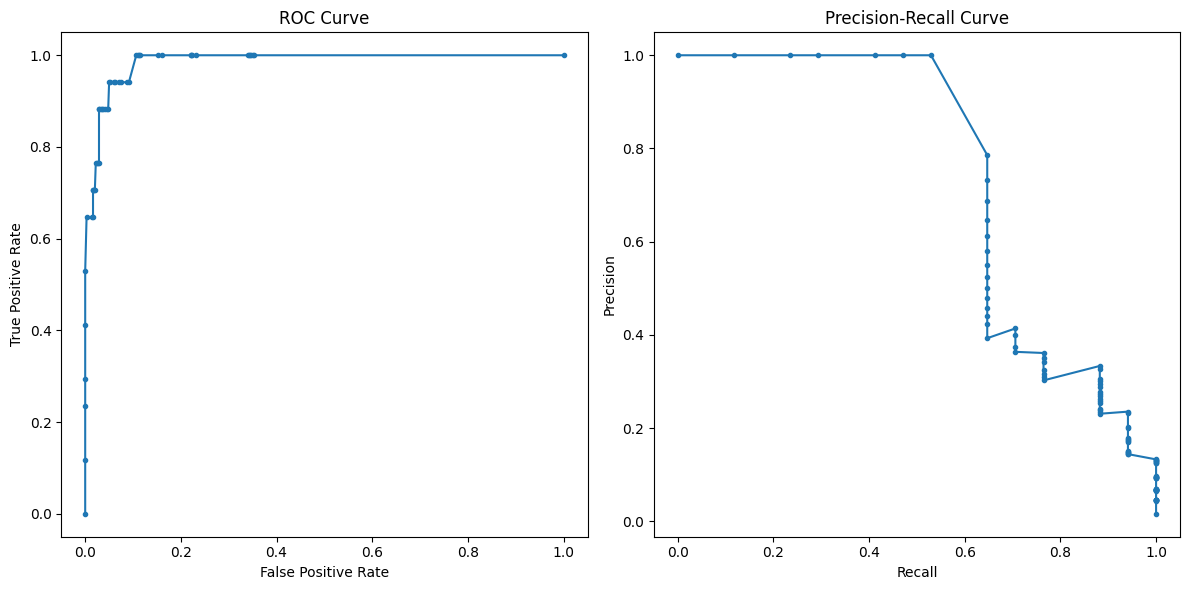

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score,
                             f1_score, confusion_matrix, classification_report,
                             log_loss, matthews_corrcoef, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

#imputer = SimpleImputer(strategy='constant', fill_value=1e10)

# Fit and transform on training data
#df_X = imputer.fit_transform(df_X)

X_train, X_test, y_train, y_test = train_test_split(df_X.astype(np.float32), Y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=400, random_state=4999)

# from xgboost import XGBClassifier

# model = XGBClassifier(
#     n_estimators=400,
#     max_depth=4,
#     learning_rate=0.01,
#     random_state=42
# )


model.fit(X_train, y_train)


# Evaluate model using cross-validation
scores = cross_val_score(model, X_test, y_test, cv=5)
print("Model Accuracy: ", np.mean(scores))

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {auc:.2f}')

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# PR Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'Log Loss: {logloss:.2f}')
print(f'Matthews Correlation Coefficient: {mcc:.2f}')

# Plot ROC Curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


In [74]:
save_object_to_disk(model, "model_1.pkl")

Object data has been serialized and saved to file.


In [73]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': df_X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
print(feature_importance_df)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

                         Feature  Importance
119                  VSA_EState4    0.022939
20             MaxAbsEStateIndex    0.020826
21                MaxEStateIndex    0.018478
42                 BCUT2D_LOGPHI    0.014726
24                           qed    0.012332
13             monoisotopic_mass    0.012244
47                      BalabanJ    0.012121
41                  BCUT2D_CHGLO    0.012052
28                    ExactMolWt    0.011903
12              molecular_weight    0.011644
48                       BertzCT    0.011402
27                HeavyAtomMolWt    0.011371
144                        MolMR    0.011321
50                         Chi0n    0.011260
25                           SPS    0.011026
22             MinAbsEStateIndex    0.010913
26                         MolWt    0.010878
65                        Kappa3    0.010862
39                  BCUT2D_MWLOW    0.010558
45                  BCUT2D_MRLOW    0.010379
19                         xlogp    0.010221
86        

# Prediction

In [64]:
file_path = 'lonicerae_clean.txt'

# Open the file and read the lines into a list
with open(file_path, 'r') as file:
    lines = file.readlines()

# Strip newline characters from each line. Also remove empty lines. Also change′ to '
lines = [line.strip().replace('′','\'') for line in lines if line.strip()]
lines = [line.replace('β','beta') for line in lines]
prediction_names = lines
prediction_names

['5,7-Dihydroxyflavone',
 "5-Hydroxy-7,4'-dimethoxyflavone",
 "5-Hydroxy-7,3',4'-trimethoxyflavone",
 "5-Hydroxy-7,3',4',5'-tetramethoxyflavone",
 "3',4',5',5,7-Pentamethoxyflavone",
 'Luteolin',
 "3'-Methoxyluteolin",
 "5,3'-Dimethoxyluteolin",
 'Luteolin-7-O-beta-D-glucoside',
 'Luteolin-7-O-beta-D-galactoside',
 'Luteolin-5-O-beta-D-glucoside',
 "Luteolin-3'-O-L-rhamnoside",
 'Jaceosidin',
 'Jaceosidin-7-O-neohesperidoside',
 'Lonicerin',
 'Kaempferol-3-O-beta-D-glucoside',
 'Apigenin-7-O-α-L-rhamnoside',
 'Quercetin',
 'Quercetin-3-O-beta-D-glucoside',
 'Quercetin-7-O-beta-D-glucoside',
 'Hyperoside',
 'Medioresinol-7-O-beta-D-glucoside',
 'Medioresinol-7-O-neohesperidoside',
 'Flavoyadorinin B',
 'Rhoifolin',
 'Rutin',
 'Loganin',
 '7-Epiloganin',
 '8-Epiloganin',
 'Loganic Acid',
 'Ketologanin',
 'Secologanin',
 'Secologanin Dimethyl Acetal',
 'Sweroside',
 '7-O-Ethyl Sweroside',
 'Secologanoside-7-Methyl Ester',
 'Kingiside',
 '7α-Morroniside',
 '7beta-Morroniside',
 'Dehydromor

In [47]:
import pubchempy as pcp

def getCompounds(names):
    data = {}
    for chemical_name in names:
        compounds = pcp.get_compounds(chemical_name, 'name')
        data[chemical_name] = compounds
    return data

In [49]:
prediction_data = getCompounds(prediction_names)

In [50]:
print(len(prediction_data.items()))
for name, compounds in prediction_data.items():
    print(name, compounds)

112
5,7-Dihydroxyflavone [Compound(5281607)]
5-Hydroxy-7,4'-dimethoxyflavone [Compound(5281601)]
5-Hydroxy-7,3',4'-trimethoxyflavone [Compound(5272653)]
5-Hydroxy-7,3',4',5'-tetramethoxyflavone []
3',4',5',5,7-Pentamethoxyflavone [Compound(493376)]
Luteolin [Compound(5280445)]
3'-Methoxyluteolin []
5,3'-Dimethoxyluteolin []
Luteolin-7-O-beta-D-glucoside []
Luteolin-7-O-beta-D-galactoside []
Luteolin-5-O-beta-D-glucoside [Compound(5317471)]
Luteolin-3'-O-L-rhamnoside []
Jaceosidin [Compound(5379096)]
Jaceosidin-7-O-neohesperidoside []
Lonicerin [Compound(5282152)]
Kaempferol-3-O-beta-D-glucoside []
Apigenin-7-O-α-L-rhamnoside []
Quercetin [Compound(5280343)]
Quercetin-3-O-beta-D-glucoside [Compound(25203368)]
Quercetin-7-O-beta-D-glucoside []
Hyperoside [Compound(5281643)]
Medioresinol-7-O-beta-D-glucoside []
Medioresinol-7-O-neohesperidoside []
Flavoyadorinin B []
Rhoifolin [Compound(5282150)]
Rutin [Compound(5280805)]
Loganin [Compound(87691)]
7-Epiloganin []
8-Epiloganin [Compound(10

In [51]:
prediction_compounds = [item for i in prediction_data.items() for item in i[1]]
prediction_features = [getFeatures(compound) for compound in prediction_compounds] 

In [68]:
X_pred = pd.DataFrame(prediction_features)
string_columns = X_pred.select_dtypes(include='object').columns.tolist()
print(string_columns) 
for i in string_columns:
    X_pred[i] = pd.to_numeric(X_pred[i])
    
Y_pred = model.predict_proba(X_pred)

['exact_mass', 'molecular_weight', 'monoisotopic_mass', 'volume_3d']


In [69]:
Y_pred

array([[0.9846945 , 0.01530549],
       [0.9888811 , 0.01111891],
       [0.9888051 , 0.01119489],
       [0.9897978 , 0.01020221],
       [0.98539925, 0.01460073],
       [0.9925163 , 0.00748372],
       [0.9885669 , 0.01143312],
       [0.99496996, 0.00503003],
       [0.9884227 , 0.01157731],
       [0.9945852 , 0.00541477],
       [0.9944816 , 0.00551838],
       [0.99496996, 0.00503003],
       [0.9949589 , 0.0050411 ],
       [0.991648  , 0.00835199],
       [0.991648  , 0.00835199],
       [0.9920296 , 0.00797039],
       [0.9922709 , 0.00772912],
       [0.9923704 , 0.00762955],
       [0.9944329 , 0.0055671 ],
       [0.9928772 , 0.00712281],
       [0.9944028 , 0.00559717],
       [0.9944015 , 0.00559848],
       [0.9944015 , 0.00559848],
       [0.9928622 , 0.00713779],
       [0.993461  , 0.00653899],
       [0.9935246 , 0.0064754 ],
       [0.9896039 , 0.0103961 ],
       [0.99130315, 0.00869684],
       [0.9914639 , 0.00853609],
       [0.99474126, 0.00525872],
       [0.

In [62]:
compounds_with_prediction = list(zip(prediction_compounds, Y_pred, prediction_features))

In [63]:
compounds_with_prediction

[(Compound(5281607),
  array([0.8852044 , 0.11479562], dtype=float32),
  {'atom_stereo_count': 0,
   'bond_stereo_count': 0,
   'charge': 0,
   'complexity': 384,
   'covalent_unit_count': 1,
   'defined_atom_stereo_count': 0,
   'defined_bond_stereo_count': 0,
   'exact_mass': '254.05790880',
   'h_bond_acceptor_count': 4,
   'h_bond_donor_count': 2,
   'heavy_atom_count': 19,
   'isotope_atom_count': 0,
   'molecular_weight': '254.24',
   'monoisotopic_mass': '254.05790880',
   'rotatable_bond_count': 1,
   'tpsa': 66.8,
   'undefined_atom_stereo_count': 0,
   'undefined_bond_stereo_count': 0,
   'volume_3d': None,
   'xlogp': 2.1,
   'MaxAbsEStateIndex': 12.003355536659107,
   'MaxEStateIndex': 12.003355536659107,
   'MinAbsEStateIndex': 0.06711215041572194,
   'MinEStateIndex': -0.3494416099773241,
   'qed': 0.700091545915688,
   'SPS': 10.736842105263158,
   'MolWt': 254.24099999999996,
   'HeavyAtomMolWt': 244.16099999999994,
   'ExactMolWt': 254.0579088,
   'NumValenceElectrons'

# Multi Class classification with DNN 

In [129]:
def getLevels(level5):
    return level5[0:1], level5[0:3], level5[0:4], level5[0:5], level5 

In [234]:
# this is out labels -- the atc classes
Y =  pd.DataFrame([getLevels(entry[2][0]) for entry in classification_features])
# give columns names
col_names = ['l1', 'l2', 'l3', 'l4', 'l5']
Y.columns = col_names

# assign a number for each class (instead of strings) -- the neural network want to see numbers instead of strings
label_encoders = {}
for level in Y.columns:
    label_encoders[level] = LabelEncoder()
    Y[level + "_enc"] = label_encoders[level].fit_transform(Y[level])
Y_encoded = Y[[level + "_enc" for level in col_names[0:1]]]
#Y_encoded = [ 1 if i == 'D10' else 0 for i in Y_encoded]

Y_encoded = (Y_encoded.values.flatten() > 0).astype(int)


In [268]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.initializers import HeNormal
from keras.layers import InputLayer, BatchNormalization
import tensorflow as tf

model = Sequential()
model.add(InputLayer(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu',  kernel_initializer=HeNormal()))     
model.add(BatchNormalization()) 
#model.add(Dense(len(label_encoders["l1"].classes_), activation='softmax')) 
model.add(Dense(1, activation='sigmoid'))  # Binary classification with sigmoid activation

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Specify learning_rate directly
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])


# Define a custom callback to print loss after each batch
class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(f'Batch {batch}, Loss: {logs["loss"]:.4f}')

In [249]:
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 32)             │         7,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,553 (29.50 KB)

 Trainable params: 7,489 (29.25 KB)

 Non-trainable params: 64 (256.00 B)

In [269]:

X_train, X_test, y_train, y_test = train_test_split(df_X, Y_encoded, test_size=0.2, random_state=22)
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2, callbacks=[PrintLossCallback()])

Batch 0, Loss: 0.6931
Batch 1, Loss: 0.6932
Batch 2, Loss: 0.6932
Batch 3, Loss: 0.6930
Batch 4, Loss: 0.6930
Batch 5, Loss: 0.6928
Batch 6, Loss: 0.6928
Batch 7, Loss: 0.6929
Batch 8, Loss: 0.6928
Batch 9, Loss: 0.6926
Batch 10, Loss: 0.6926
Batch 11, Loss: 0.6925
Batch 12, Loss: 0.6925
Batch 13, Loss: 0.6923
Batch 14, Loss: 0.6925
Batch 15, Loss: 0.6924
Batch 16, Loss: 0.6923
Batch 17, Loss: 0.6922
Batch 18, Loss: 0.6921
Batch 19, Loss: 0.6923
Batch 20, Loss: 0.6926
Batch 21, Loss: 0.6923
Batch 22, Loss: 0.6922
Batch 23, Loss: 0.6920
Batch 24, Loss: 0.6920
Batch 25, Loss: 0.6918
Batch 26, Loss: 0.6916
Batch 27, Loss: 0.6915
Batch 28, Loss: 0.6915
Batch 29, Loss: 0.6914
Batch 30, Loss: 0.6913
Batch 31, Loss: 0.6912
Batch 32, Loss: 0.6912
Batch 33, Loss: 0.6911
Batch 34, Loss: 0.6911
Batch 35, Loss: 0.6909
Batch 36, Loss: 0.6908
Batch 37, Loss: 0.6906
Batch 38, Loss: 0.6905
Batch 39, Loss: 0.6905
Batch 40, Loss: 0.6904
Batch 41, Loss: 0.6903
Batch 42, Loss: 0.6903
Batch 43, Loss: 0.690

In [260]:
predictions = model.predict(X_train[0:3])
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[nan],
       [nan],
       [nan]], dtype=float32)

In [343]:
X_train.columns.values


array(['atom_stereo_count', 'bond_stereo_count', 'charge', 'complexity',
       'covalent_unit_count', 'defined_atom_stereo_count',
       'defined_bond_stereo_count', 'exact_mass', 'h_bond_acceptor_count',
       'h_bond_donor_count', 'heavy_atom_count', 'isotope_atom_count',
       'molecular_weight', 'monoisotopic_mass', 'rotatable_bond_count',
       'tpsa', 'undefined_atom_stereo_count',
       'undefined_bond_stereo_count', 'volume_3d', 'xlogp',
       'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt',
       'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons',
       'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2',
       'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI',
       'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', '

In [261]:
X_train.select_dtypes(include='object').columns.tolist()

[]

In [262]:
torch.tensor([0, 1, 2, 1, 0]).size()

torch.Size([5])

In [ ]:
X_train_tensor[0]

tensor([ 6.0000e+00,  0.0000e+00,  0.0000e+00,  6.0900e+02,  1.0000e+00,
         4.0000e+00,  0.0000e+00,  3.1519e+02,  4.0000e+00,  2.0000e+00,
         2.3000e+01,  0.0000e+00,  3.1540e+02,  3.1519e+02,  2.0000e+00,
         9.0400e+01,  2.0000e+00,  0.0000e+00, -1.0000e+00,  7.0000e-01,
         1.3140e+01,  1.3140e+01,  2.1204e-02, -5.9351e-01,  7.9981e-01,
         5.3783e+01,  3.1542e+02,  2.9022e+02,  3.1519e+02,  1.2400e+02,
         0.0000e+00,  2.4089e-01, -3.8985e-01,  3.8985e-01,  2.4089e-01,
         1.2174e+00,  1.9130e+00,  2.5217e+00,  1.6284e+01,  9.4585e+00,
         2.6226e+00, -2.6138e+00,  2.6261e+00, -2.6445e+00,  5.8424e+00,
        -1.7702e-01,  3.1354e+00,  1.4299e+00,  5.9788e+02,  1.5983e+01,
         1.3448e+01,  1.3448e+01,  1.0929e+01,  9.1278e+00,  9.1278e+00,
         9.2146e+00,  9.2146e+00,  7.5091e+00,  7.5091e+00,  6.9597e+00,
         6.9597e+00, -1.1200e+00,  3.3839e+05,  1.4242e+01,  4.2858e+00,
         1.8824e+00,  1.3636e+02,  1.5740e+01,  6.0

In [135]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import clip_grad_norm_

dtype=torch.float64
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=dtype)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).squeeze()

# Important: any NaN should be set to a special value here (e.g., -1), otherwise the loss will always be NaN
nan_mask = torch.isnan(X_train_tensor)
X_train_tensor[nan_mask] = -1.000000000

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define model architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, dtype=dtype)
        self.bn1 = nn.BatchNorm1d(hidden_size, dtype=dtype)  # Batch normalization layer
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_size, hidden_size, dtype=dtype)
        self.bn2 = nn.BatchNorm1d(hidden_size, dtype=dtype)  # Batch normalization layer
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, num_classes, dtype=dtype)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)  # Apply batch normalization
        out = self.relu1(out)
        
        out = self.fc2(out)
        out = self.bn2(out)  # Apply batch normalization
        out = self.relu2(out)
        
        out = self.fc3(out)
        
        return out


num_features = X_train.shape[1]
num_classes = len(label_encoders["l1"].classes_)

# Initialize model, loss function, and optimizer
model = NeuralNetwork(input_size=num_features, hidden_size=32, num_classes=14)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)

        # Calculate loss
        loss = criterion(outputs, batch_y)
        
        epoch_loss += loss.item()
        #print(epoch_loss)

        #if (loss.item() < 100000):
        # Backward pass and optimize
        loss.backward()
        
        #clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

    # Print epoch loss (optional)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on training data (not recommended for final evaluation)
with torch.no_grad():
    outputs = model(X_train_tensor)
    _, predicted = torch.max(outputs, 1)  # Get predicted classes
    print(predicted)
    accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)
    print(f'Training Accuracy: {accuracy:.4f}')

AttributeError: 'list' object has no attribute 'values'

In [ ]:
X_train_np = X_train.values
X_train_np[0]

array([ 8.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.96000000e+03,
        1.00000000e+00,  8.00000000e+00,  0.00000000e+00,  1.03053485e+03,
        1.40000000e+01,  1.30000000e+01,  7.40000000e+01,  0.00000000e+00,
        1.03120000e+03,  1.03053485e+03,  2.80000000e+01,  4.15000000e+02,
        0.00000000e+00,  0.00000000e+00,             nan, -2.70000000e+00,
        1.45092084e+01,  1.45092084e+01,  9.05010716e-03, -1.40179353e+00,
        2.77659911e-02,  1.81486486e+01,  1.03118600e+03,  9.60626000e+02,
        1.03053485e+03,  4.02000000e+02,  0.00000000e+00,  3.28407861e-01,
       -5.07966645e-01,  5.07966645e-01,  3.28407861e-01,  7.43243243e-01,
        1.31081081e+00,  1.86486486e+00,  1.63692894e+01,  1.00158098e+01,
        2.38150095e+00, -2.27137594e+00,  2.23753541e+00, -2.46425198e+00,
        5.94477487e+00, -1.38007725e-01,  4.05909884e+00,  1.74184488e+00,
        2.51499828e+03,  5.46469602e+01,  4.17692517e+01,  4.17692517e+01,
        3.50336004e+01,  

In [136]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import to_categorical

# Load the dataset
data = pd.read_csv('your_dataset.csv')

# Encode categorical target variables
label_encoders = {}
for level in ['Level1', 'Level2', 'Level3', 'Level4', 'Level5']:
    label_encoders[level] = LabelEncoder()
    data[level] = label_encoders[level].fit_transform(data[level])

# Split features and target variables
X = data.drop(['Level1', 'Level2', 'Level3', 'Level4', 'Level5'], axis=1)
y = data[['Level1', 'Level2', 'Level3', 'Level4', 'Level5']]

# Convert target variables to categorical
y_encoded = {level: to_categorical(y[level]) for level in y.columns}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the neural network architecture
input_layer = Input(shape=(X_train.shape[1],))

# Shared hidden layers
shared_layer = Dense(128, activation='relu')(input_layer)
shared_layer = Dense(64, activation='relu')(shared_layer)

# Output layers for each level
outputs = []
for level in y.columns:
    output_layer = Dense(len(label_encoders[level].classes_), activation='softmax', name=level)(shared_layer)
    outputs.append(output_layer)

# Define the model
model = Model(inputs=input_layer, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, [y_train[level] for level in y.columns], epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
for i, level in enumerate(y.columns):
    y_pred_classes = y_pred[i].argmax(axis=1)
    y_true = y_test[level].argmax(axis=1)
    print(f'Level {i+1} Accuracy: {accuracy_score(y_true, y_pred_classes):.2f}')
    print(f'Level {i+1} Classification Report:')
    print(classification_report(y_true, y_pred_classes))

FileNotFoundError: [Errno 2] No such file or directory: 'your_dataset.csv'